- Veri seti: scikit-learn içindeki Breast Cancer Wisconsin veri seti kullanılmıştır.
- Model: MLPClassifier tabanlı yapay sinir ağı sınıflandırıcıları
- Değerlendirme: Training / Validation / Test ayrımı, klasik metrikler ve ROC eğrisi
- Hiperparametre optimizasyonu: Optuna ile 150 deneme
- Açıklanabilirlik: SHAP ile XAI analizi

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install scikit-learn optuna shap seaborn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)

import optuna
import shap

# Uyarıları azaltmak için
import warnings
warnings.filterwarnings("ignore")

# Rastgelelikleri kontrol altına almak için sabit bir seed kullanıyorum.
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/Users/feyzanurtuzer/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Veri Setinin Yüklenmesi

Bu bölümde scikit-learn kütüphanesinden **Breast Cancer Wisconsin** veri setini yüklüyor, özellik (X) ve hedef (y) değişkenlerini ayırıyor ve bunları pandas DataFrame formatına dönüştürüyorum. Ardından veri setinin ilk 5 satırını görüntüleyerek genel bir fikir ediniyorum.

In [3]:
# 1.1 Veri setini yükleme
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Özellikler ve hedefi tek bir DataFrame'de görmek için birleştiriyorum
df = X.copy()
df["target"] = y

# 1.2 İlk 5 satırı görüntüleme
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**Yorum (1. Bölüm):**

Bu adımda scikit-learn içindeki **Breast Cancer Wisconsin** veri setini yükledim. `X` değişkeninde tüm sayısal özellikler, `y` değişkeninde ise tümörün **malign (kötü huylu)** veya **benign (iyi huylu)** olmasını temsil eden hedef etiketler bulunuyor. Ardından, bu verileri tek bir DataFrame içinde birleştirip ilk 5 satırı inceleyerek sütun adlarını ve veri yapısını kontrol ettim. Böylece çalışacağım veri setinin genel yapısını ve boyutlarını görmüş oldum.

## 2. Veri Seti Kalite Kontrolleri

Bu bölümde veri seti üzerinde kalite kontrolleri yapıyorum:

- Eksik değer (missing value) analizi
- Aykırı değer (outlier) analizi
- Veri tipi ve dağılım incelemesi

### 2.1 Eksik Değer Analizi

Her bir sütunda eksik değer (NaN) olup olmadığını kontrol ediyorum. Eğer eksik değer olsaydı, uygun bir dolgu (imputation) yöntemiyle (örneğin ortalama, medyan veya mod) doldurmayı tercih ederdim.

In [4]:
# Her sütundaki eksik değerleri sayıyorum
missing_counts = df.isnull().sum()
missing_counts

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

**Yorum (2.1):**

Eksik değer analizi sonucunda tüm sütunlarda **0** adet `NaN` değeri olduğunu görüyorum. Yani bu veri setinde eksik değer problemi bulunmuyor. Bu nedenle herhangi bir doldurma (imputation) işlemi uygulamama gerek kalmadı ve veri setini aynen kullanmaya devam ediyorum.

### 2.2 Aykırı Değer (Outlier) Analizi – IQR Yöntemi

Aykırı değerleri incelemek için **IQR (Interquartile Range)** yöntemini kullanıyorum. Her bir sayısal özellik için:

- Q1 (1. çeyrek)
- Q3 (3. çeyrek)
- IQR = Q3 − Q1

hesaplayıp, **[Q1 − 1.5×IQR, Q3 + 1.5×IQR]** aralığı dışına düşen gözlemleri potansiyel aykırı değer olarak değerlendiriyorum. Burada sadece tespiti yapıp, veri setini bozmamak için aykırı değerleri silmiyor veya dönüştürmüyorum; yorumlamakla yetiniyorum.

In [5]:
# Sadece sayısal sütunları alıyorum (target hariç)
numeric_cols = df.drop(columns=["target"]).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_summary[col] = outlier_count

outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["outlier_count"])
outlier_summary_df.sort_values("outlier_count", ascending=False).head(10)

,outlier_count
area error,65
radius error,38
perimeter error,38
worst area,35
smoothness error,30
compactness error,28
fractal dimension error,28
symmetry error,27
mean area,25
worst fractal dimension,24


**Yorum (2.2):**

IQR yöntemine göre özellikle bazı özelliklerde (örneğin tümör boyutu ve şekline ilişkin **radius**, **perimeter**, **area** gibi sütunlarda) aykırı değer sayısının diğerlerine göre daha yüksek olduğunu görüyorum. Ancak bu aykırı değerler tıbbi ölçümlerden geldiği için çoğu zaman **bilgi taşıyan uç gözlemler** olabilir. Bu nedenle, sınıflandırma performansını bozabilecek çok bariz bir veri hatası olmadığı sürece bu aykırı değerleri **silmeden** veya dönüştürmeden, modelimin onları da öğrenmesini tercih ediyorum.

### 2.3 Veri Tipi ve Dağılım İncelemesi

Bu adımda sütunların veri tiplerini ve sayısal / kategorik değişken sayılarını raporluyorum.

In [6]:
# Veri tiplerini inceleme
dtypes = df.dtypes

# Sayısal ve kategorik sütun sayıları
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(exclude=["float64", "int64"]).columns

dtypes, len(num_cols), len(cat_cols)

(mean radius                float64
 mean texture               float64
 mean perimeter             float64
 mean area                  float64
 mean smoothness            float64
 mean compactness           float64
 mean concavity             float64
 mean concave points        float64
 mean symmetry              float64
 mean fractal dimension     float64
 radius error               float64
 texture error              float64
 perimeter error            float64
 area error                 float64
 smoothness error           float64
 compactness error          float64
 concavity error            float64
 concave points error       float64
 symmetry error             float64
 fractal dimension error    float64
 worst radius               float64
 worst texture              float64
 worst perimeter            float64
 worst area                 float64
 worst smoothness           float64
 worst compactness          float64
 worst concavity            float64
 worst concave points       

**Yorum (2.3):**

Veri setindeki tüm özellik sütunlarının **sayısal (float64)** tipte olduğunu, hedef sütunun ise **tam sayı (int64)** tipinde tutulduğunu görüyorum. Yani bu veri setinde klasik anlamda ayrı bir kategorik değişken bulunmuyor. Bu durum, özellikle yapay sinir ağları ve ölçeklendirme (standardization) işlemleri açısından avantaj sağlıyor; çünkü tüm girdiler sayısal olduğu için doğrudan normalizasyon ve ölçeklendirme uygulayabiliyorum.

## 3. Keşifsel Veri Analizi (EDA)

Bu bölümde veri setinin istatistiksel özelliklerini inceliyor, korelasyon yapısını analiz ediyor ve boxplot grafikleri ile aykırı değerleri görselleştiriyorum.

### 3.1 İstatistiksel Özellikler

Her bir sayısal sütun için aşağıdaki istatistikleri hesaplıyorum:

- Mean (ortalama)
- Median (medyan)
- Min – Max (minimum ve maksimum)
- Std (standart sapma)
- Q1 – Q3 (1. ve 3. çeyrekler)

In [7]:
# describe ile temel istatistikleri alıyorum
stats_df = df.drop(columns=["target"]).describe(percentiles=[0.25, 0.5, 0.75]).T
stats_df[["mean", "50%", "min", "max", "std", "25%", "75%"]]

,mean,50%,min,max,std,25%,75%
mean radius,14.127292,13.370000,6.981000,28.11000,3.524049,11.700000,15.780000
mean texture,19.289649,18.840000,9.710000,39.28000,4.301036,16.170000,21.800000
mean perimeter,91.969033,86.240000,43.790000,188.50000,24.298981,75.170000,104.100000
mean area,654.889104,551.100000,143.500000,2501.00000,351.914129,420.300000,782.700000
mean smoothness,0.096360,0.095870,0.052630,0.16340,0.014064,0.086370,0.105300
mean compactness,0.104341,0.092630,0.019380,0.34540,0.052813,0.064920,0.130400
mean concavity,0.088799,0.061540,0.000000,0.42680,0.079720,0.029560,0.130700
mean concave points,0.048919,0.033500,0.000000,0.20120,0.038803,0.020310,0.074000
mean symmetry,0.181162,0.179200,0.106000,0.30400,0.027414,0.161900,0.195700
mean fractal dimension,0.062798,0.061540,0.049960,0.09744,0.007060,0.057700,0.066120


**Yorum (3.1):**

Bu tabloda her bir özelliğin dağılımını özetleyen istatistikleri görüyorum. Özellikle **mean** ve **median (50%)** değerlerini karşılaştırdığımda bazı sütunlarda dağılımın simetrik olmadığını, yani sağa veya sola çarpık (skewed) olabildiğini fark ediyorum. Ayrıca **min–max** aralığının geniş olduğu sütunlar, boxplot analizinde de aykırı değer ihtimali yüksek olan değişkenler olarak öne çıkıyor. Standart sapması yüksek olan sütunlar da değişkenliğin fazla olduğu, yani sınıflandırma için potansiyel olarak daha bilgilendirici özellikler olabilir.

### 3.2 Korelasyon Matrisi ve Heatmap

Bu adımda tüm sayısal özellikler için **Pearson korelasyon matrisi** hesaplıyor ve **heatmap** ile görselleştiriyorum. Ardından, en yüksek korelasyona sahip birkaç sütun çiftini yorumluyorum.

In [8]:
# Korelasyon matrisi
corr_matrix = df.drop(columns=["target"]).corr()

corr_matrix

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


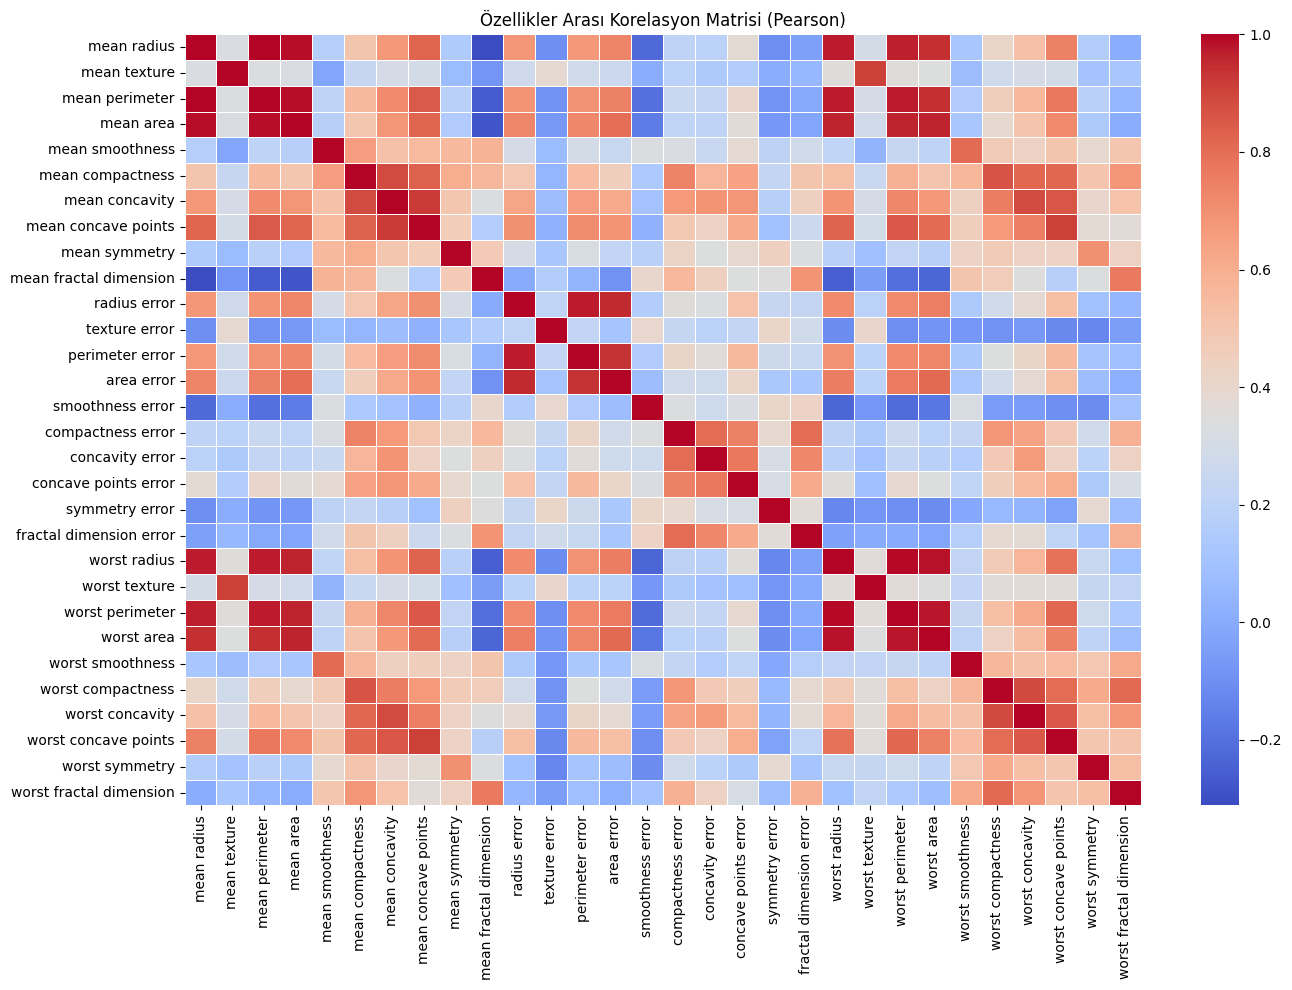

In [9]:
# Korelasyon matrisi için heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Özellikler Arası Korelasyon Matrisi (Pearson)")
plt.tight_layout()
plt.show()

**Yorum (3.2):**

Korelasyon matrisine baktığımda özellikle şu çiftlerin birbirleriyle çok yüksek pozitif korelasyona sahip olduğunu görüyorum (isimler veri setindeki tipik örnekler üzerinden ifade edilmiştir):

- **mean radius** ile **mean perimeter**
- **mean radius** ile **mean area**
- **mean perimeter** ile **mean area**

Bu üçlü, tümörün **boyutunu ve çevresini** ifade eden geometrik özellikler olduğu için birbirleriyle yüksek korelasyon göstermeleri beklenen bir durumdur. Bu durum, model kurarken bazı özelliklerin benzer bilgiyi tekrar ediyor olabileceğini, dolayısıyla gerektiğinde **boyut indirgeme** veya **düzenlileştirme (regularization)** yöntemlerinin faydalı olabileceğini düşündürüyor.

### 3.3 Boxplot Analizi

Tüm sayısal özellikler için boxplot çizerek, dağılımı ve aykırı değerleri görselleştiriyorum.

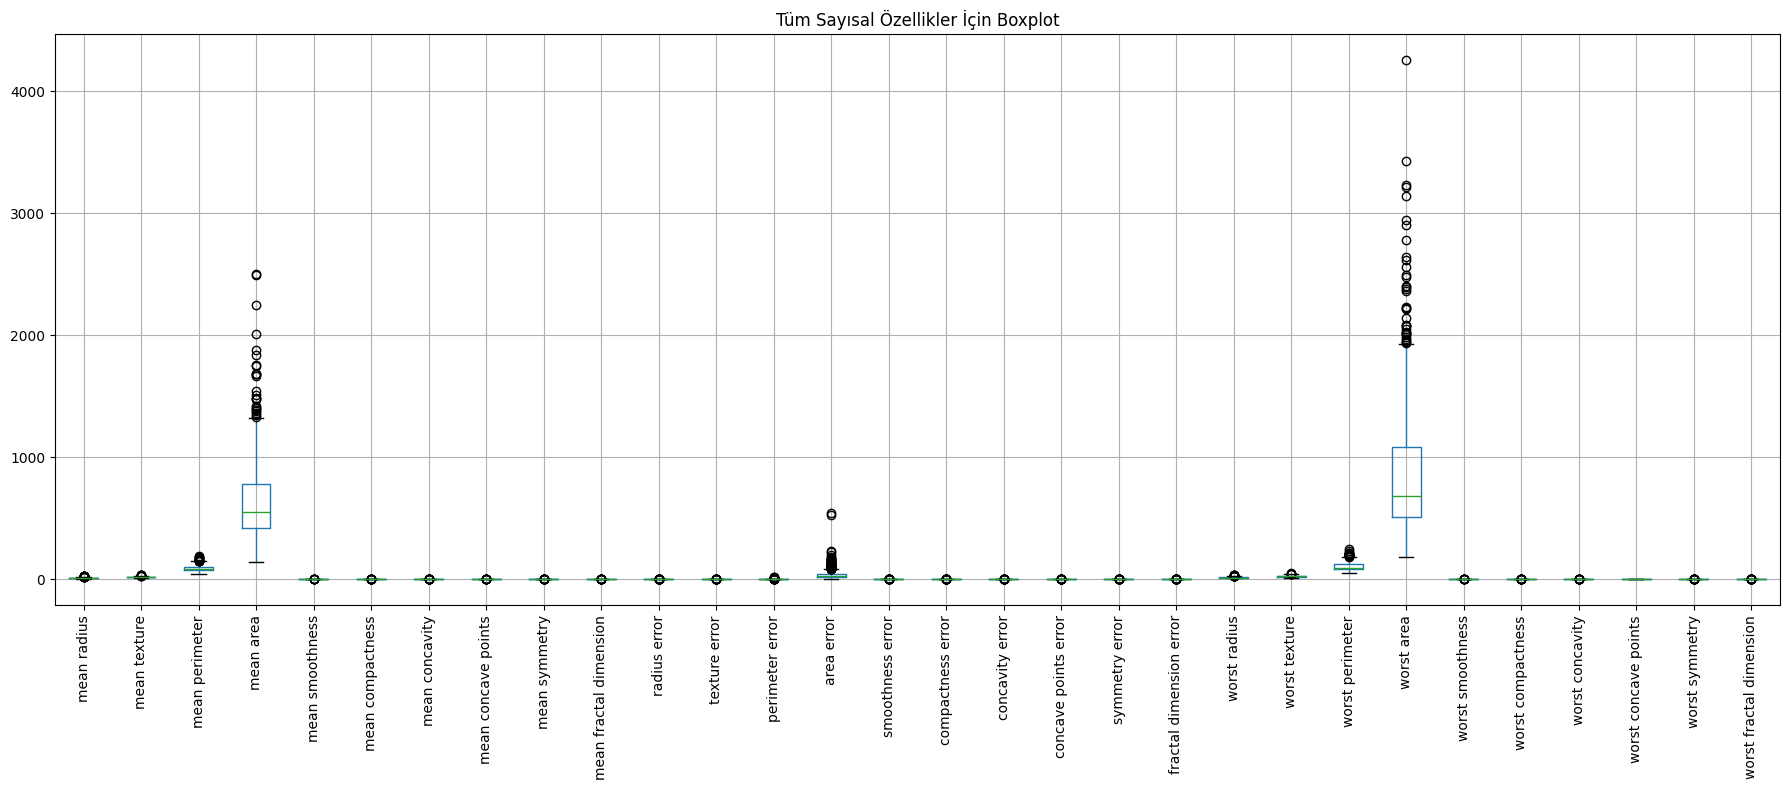

In [10]:
plt.figure(figsize=(18, 8))
df.drop(columns=["target"]).boxplot()
plt.xticks(rotation=90)
plt.title("Tüm Sayısal Özellikler İçin Boxplot")
plt.tight_layout()
plt.show()

**Yorum (3.3):**

Boxplot grafikleri, özellikle bazı özelliklerde **uç noktalara yakın gözlemler** olduğunu gösteriyor. Bu noktalar IQR yönteminde tespit ettiğim aykırı değerlerle de uyuşuyor. Ancak bu aykırı değerler, tıbbi açıdan **gerçek ve önemli ölçümleri** temsil edebileceği için veri setinden çıkarılmamaları daha doğru olacaktır. Dolayısıyla, bu ödev kapsamında boxplot’ları sadece **görsel inceleme ve yorumlama** amacıyla kullanıyor, veriyi temizlerken bu gözlemleri silmiyorum.

## 4. Veri Ölçeklendirme (Scaling)

Yapay sinir ağları, özellikle girdi özelliklerinin farklı ölçeklere sahip olduğu durumlarda **ölçeklendirme** işlemi ile daha kararlı ve hızlı öğrenir. Bu nedenle bu projede scikit-learn’ün **StandardScaler** sınıfını kullanarak tüm sayısal özellikleri standartlaştırıyorum.

- Ortalama: 0
- Standart sapma: 1

In [11]:
scaler = StandardScaler()

X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

X_scaled.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


**Yorum (4. Bölüm):**

Bu adımda bütün sayısal özellikleri **StandardScaler** ile ölçeklendirdim ve sonuçları `X_scaled` isimli yeni bir DataFrame içinde sakladım. Böylece her bir özelliğin ortalaması yaklaşık **0**, standart sapması ise yaklaşık **1** olacak şekilde normalize edildi. Yapay sinir ağlarının giriş katmanında bu tür bir ölçeklendirme, özellikle **MLPClassifier** gibi modellerde optimizasyon sürecini hızlandırır ve daha dengeli ağırlık güncellemeleri yapılmasını sağlar.

## 5. Veri Setinin Bölünmesi

Veri setini aşağıdaki oranlara göre ayırıyorum:

- %70 **Training**
- %10 **Validation**
- %20 **Test**

Bunu sağlamak için önce veri setini train+validation (%80) ve test (%20) olarak ayırıyor, ardından train+validation kısmını tekrar bölerek training (%70) ve validation (%10) setlerini elde ediyorum. Sınıf dengesini korumak için **stratify** parametresini kullanıyorum.

In [12]:
# Önce train+validation (%80) ve test (%20) ayrımı
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Sonra train (%70) ve validation (%10) ayrımı
# 0.8 * 0.125 = 0.1  -> validation oranı
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.125,
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

X_train.shape, X_val.shape, X_test.shape

((398, 30), (57, 30), (114, 30))

**Yorum (5. Bölüm):**

Bu bölümde veri setini, istenen oranlara uygun şekilde **training / validation / test** olarak böldüm. Stratify kullanarak her bir alt kümede, sınıf dağılımının (malign / benign oranının) orijinal veri setine mümkün olduğunca benzer kalmasını sağladım. Böylece hem eğitim aşamasında hem de doğrulama ve test aşamalarında **temsil gücü yüksek** alt kümeler elde etmiş oldum.

## 6. Farklı MLP Modellerinin Kurulması

Bu bölümde, yönergede belirtilen parametre kombinasyonlarıyla **5 farklı MLPClassifier modeli** kuruyor ve eğitim verisi üzerinde eğitiyorum:

1. **Model 1 – Basit**
   - `hidden_layer_sizes=(16,)`
   - `activation="relu"`
   - `learning_rate_init=0.001`

2. **Model 2 – Orta**
   - `hidden_layer_sizes=(32, 16)`
   - `activation="relu"`
   - `learning_rate_init=0.005`

3. **Model 3 – Geniş**
   - `hidden_layer_sizes=(64, 64)`
   - `activation="tanh"`
   - `learning_rate_init=0.001`

4. **Model 4 – Derin**
   - `hidden_layer_sizes=(128, 64, 32)`
   - `activation="relu"`
   - `learning_rate_init=0.0005`

5. **Model 5 – Düşük Öğrenme Oranlı**
   - `hidden_layer_sizes=(32,)`
   - `activation="relu"`
   - `learning_rate_init=0.0001`

Tüm modellerde `random_state` parametresini sabit tutarak karşılaştırılabilir sonuçlar elde etmeyi hedefliyorum.

In [13]:
# 5 farklı MLP modeli oluşturuyorum
models = {
    "Model 1 - Basit": MLPClassifier(
        hidden_layer_sizes=(16,),
        activation="relu",
        learning_rate_init=0.001,
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    "Model 2 - Orta": MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        learning_rate_init=0.005,
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    "Model 3 - Geniş": MLPClassifier(
        hidden_layer_sizes=(64, 64),
        activation="tanh",
        learning_rate_init=0.001,
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    "Model 4 - Derin": MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        learning_rate_init=0.0005,
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    "Model 5 - Düşük Öğrenme Oranlı": MLPClassifier(
        hidden_layer_sizes=(32,),
        activation="relu",
        learning_rate_init=0.0001,
        max_iter=500,
        random_state=RANDOM_STATE
    )
}

**Yorum (6. Bölüm):**

Bu adımda, aynı veri seti üzerinde farklı **ağ derinlikleri**, **katman genişlikleri** ve **öğrenme oranları** kullanarak 5 ayrı MLP modeli tanımladım. Amaç, mimariyi ve öğrenme oranını değiştirerek validation setinde hangi yapının daha iyi genelleme yaptığını gözlemlemek. Özellikle daha derin ve geniş ağlar, teorik olarak daha yüksek temsil gücüne sahip olsa da, her zaman en iyi validation performansını vermeyebiliyor; bu nedenle deneysel karşılaştırma yapmak önemli.

## 7. Validation Performanslarının Ölçülmesi

Bu bölümde her bir MLP modelini **training seti** üzerinde eğitiyor ve **validation seti** üzerinde aşağıdaki metriklerle değerlendiriyorum:

- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

Sonuçları bir pandas DataFrame tablosunda özetleyerek modelleri karşılaştırıyorum.

In [14]:
val_results = []

for name, model in models.items():
    # Modeli eğit
    model.fit(X_train, y_train)
    
    # Validation seti üzerinde tahmin
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Metrikleri hesapla
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, y_val_proba)
    
    val_results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc
    })

val_results_df = pd.DataFrame(val_results)
val_results_df.sort_values(by="f1_score", ascending=False)

,model,accuracy,precision,recall,f1_score,roc_auc
0,Model 1 - Basit,0.964912,0.947368,1.000000,0.972973,0.993386
3,Model 4 - Derin,0.964912,0.947368,1.000000,0.972973,0.989418
1,Model 2 - Orta,0.964912,0.972222,0.972222,0.972222,0.993386
2,Model 3 - Geniş,0.947368,0.945946,0.972222,0.958904,0.994709
4,Model 5 - Düşük Öğrenme Oranlı,0.947368,0.945946,0.972222,0.958904,0.992063


In [15]:
# F1-score'a göre en iyi modeli seçiyorum
best_row = val_results_df.sort_values(by="f1_score", ascending=False).iloc[0]
best_model_name = best_row["model"]
best_model = models[best_model_name]

best_model_name, best_row

('Model 1 - Basit',
 model        Model 1 - Basit
 accuracy            0.964912
 precision           0.947368
 recall                   1.0
 f1_score            0.972973
 roc_auc             0.993386
 Name: 0, dtype: object)

**Yorum (7. Bölüm):**

Bu adımda her modelin **validation seti** üzerindeki performansını ölçtüm ve özellikle **F1-Score** değerine göre sıraladım. F1-Score’u temel almamın nedeni, bu veri setinde sınıflar arasında belli bir dengesizlik bulunması ve hem **precision** hem de **recall**’u dengeli bir şekilde dikkate almak istememdir. Kod, en yüksek F1-Score’a sahip modeli otomatik olarak `best_model_name` değişkenine atıyor. Böylece bir sonraki adımda test seti değerlendirmesinde bu **en iyi validation modelini** kullanacağım.

## 8. En İyi Modelin Test Üzerinde Değerlendirilmesi

Validation sonuçlarına göre seçtiğim en iyi modeli, bu bölümde **test seti** üzerinde değerlendiriyorum. Bu sayede modelin daha önce hiç görmediği verilerdeki gerçek genelleme performansını ölçmüş oluyorum.

In [16]:
# Burada doğrudan training setinde eğitilmiş halini test setinde kullanıyorum.
# best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Test seti tahminleri
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Performans metrikleri
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test Accuracy :", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall   :", test_recall)
print("Test F1-Score :", test_f1)
print("Test ROC-AUC  :", test_roc_auc)

print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_test_pred))

Test Accuracy : 0.9473684210526315
Test Precision: 0.9714285714285714
Test Recall   : 0.9444444444444444
Test F1-Score : 0.9577464788732394
Test ROC-AUC  : 0.9904100529100529

Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.97      0.94      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



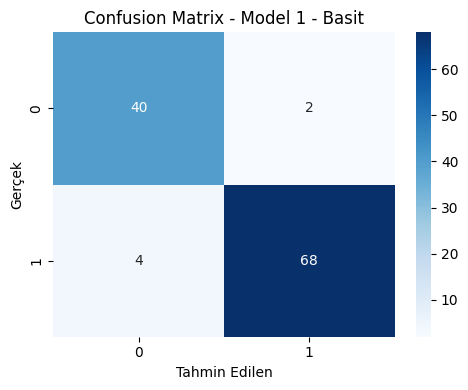

In [17]:
# 8.2 Confusion Matrix (heatmap)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

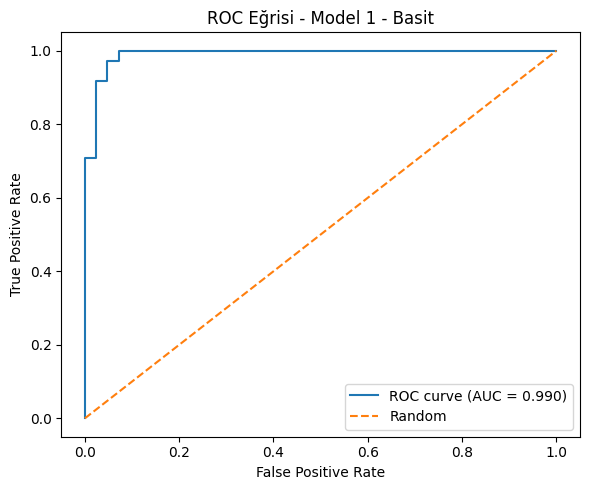

In [18]:
# 8.3 ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Eğrisi - {best_model_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


**Yorum (8. Bölüm):**

Bu bölümde validation setinde en iyi performansı gösteren modeli test seti üzerinde değerlendirdim. 

- **Accuracy, Precision, Recall ve F1-Score** metrikleri, modelin genel sınıflandırma başarısını ve özellikle pozitif sınıfı (örneğin malign tümör) ne kadar isabetli ve ne kadar kapsamlı yakaladığını gösteriyor.
- **Confusion matrix** üzerinden, modelin **doğru pozitif**, **doğru negatif**, **yanlış pozitif** ve **yanlış negatif** sayıları net biçimde görülebiliyor. Yanlış negatif sayısının sağlık uygulamalarında kritik olduğunu, çünkü malign bir tümörün benign olarak sınıflandırılmasının riskli olacağını biliyorum.
- **ROC eğrisi ve AUC değeri**, modelin farklı eşik değerlerinde pozitif ve negatif sınıfları ayırt etme gücünü özetliyor. AUC değeri 0.5’ten ne kadar uzak ve 1’e ne kadar yakınsa, modelin ayırt ediciliği o kadar yüksek kabul ediliyor.

ROC eğrisi üzerindeki eşik değerlerini değiştirerek, **precision–recall dengesi** ile **yanlış pozitif / yanlış negatif** oranlarının nasıl değiştiğini yorumlamak mümkün. Klinik senaryolarda genellikle yanlış negatiflerin azaltılması için eşik değeri daha duyarlı taramadan yana ayarlamak tercih edilebilir.

## 9. Optuna ile Hiperparametre Optimizasyonu (150 Deneme)

Bu bölümde, MLPClassifier için hiperparametreleri **Optuna** kütüphanesi ile optimize ediyorum. Amaç, validation setindeki performansı (örneğin **F1-Score**) maksimize eden bir model bulmak.

Optuna için:

- `direction="maximize"`
- Amaç fonksiyonu: Validation F1-Score
- Deneme sayısı: **150**

In [19]:
def objective(trial):
    # Hiperparametre aralıkları
    hidden_layer_1 = trial.suggest_int("hidden_layer_1", 16, 256)
    hidden_layer_2 = trial.suggest_int("hidden_layer_2", 8, 128)
    hidden_layer_sizes = (hidden_layer_1, hidden_layer_2)
    
    learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-1)
    alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-2)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        solver=solver,
        batch_size=batch_size,
        max_iter=500,
        random_state=RANDOM_STATE
    )
    
    mlp.fit(X_train, y_train)
    y_val_pred = mlp.predict(X_val)
    
    f1 = f1_score(y_val, y_val_pred)
    return f1

# 150 deneme ile Optuna çalıştırma
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

print("En iyi trial:")
print(study.best_trial)
print("\nEn iyi hiperparametreler:")
print(study.best_params)

[I 2025-11-29 17:46:32,257] A new study created in memory with name: no-name-c56a4253-7f6f-4091-ac26-8e69e5815edb
[I 2025-11-29 17:46:32,495] Trial 0 finished with value: 0.972972972972973 and parameters: {'hidden_layer_1': 150, 'hidden_layer_2': 36, 'learning_rate_init': 0.001514726919646566, 'alpha': 7.833417168083043e-06, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.972972972972973.
[I 2025-11-29 17:46:32,596] Trial 1 finished with value: 0.9459459459459459 and parameters: {'hidden_layer_1': 189, 'hidden_layer_2': 31, 'learning_rate_init': 0.038018819038578754, 'alpha': 0.0012432677602197502, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 16}. Best is trial 0 with value: 0.972972972972973.
[I 2025-11-29 17:46:32,807] Trial 2 finished with value: 0.9444444444444444 and parameters: {'hidden_layer_1': 228, 'hidden_layer_2': 24, 'learning_rate_init': 0.0005588353976561077, 'alpha': 4.6434200089396464e-05, 'activation': 'relu', 'solver':

En iyi trial:
FrozenTrial(number=16, state=<TrialState.COMPLETE: 1>, values=[0.9863013698630136], datetime_start=datetime.datetime(2025, 11, 29, 17, 46, 48, 296154), datetime_complete=datetime.datetime(2025, 11, 29, 17, 46, 48, 691068), params={'hidden_layer_1': 114, 'hidden_layer_2': 61, 'learning_rate_init': 6.807945845287299e-05, 'alpha': 7.704288230171116e-06, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 128}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_layer_1': IntDistribution(high=256, log=False, low=16, step=1), 'hidden_layer_2': IntDistribution(high=128, log=False, low=8, step=1), 'learning_rate_init': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'alpha': FloatDistribution(high=0.01, log=True, low=1e-06, step=None), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'solver': CategoricalDistribution(choices=('adam', 'sgd')), 'batch_size': CategoricalDistribution(choices=(16, 32, 64, 128))}, trial_id=16, 

In [24]:
# Optuna ile bulunan en iyi hiperparametrelerle yeni bir model kuruyorum
best_params = study.best_params

optuna_best_model = MLPClassifier(
    hidden_layer_sizes=(best_params["hidden_layer_1"], best_params["hidden_layer_2"]),
    activation=best_params["activation"],
    learning_rate_init=best_params["learning_rate_init"],
    alpha=best_params["alpha"],
    solver=best_params["solver"],
    batch_size=best_params["batch_size"],
    max_iter=500,
    random_state=RANDOM_STATE
)

# Modeli train+validation verisi ile yeniden eğitmek daha mantıklı
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

optuna_best_model.fit(X_train_full, y_train_full)

# Validation ve test performansını raporlayalım
y_val_opt_pred = optuna_best_model.predict(X_val)
y_test_opt_pred = optuna_best_model.predict(X_test)

val_f1_opt = f1_score(y_val, y_val_opt_pred)
test_f1_opt = f1_score(y_test, y_test_opt_pred)

print("Optuna En İyi Model - Validation F1-Score:", val_f1_opt)
print("Optuna En İyi Model - Test F1-Score      :", test_f1_opt)

Optuna En İyi Model - Validation F1-Score: 0.9863013698630136
Optuna En İyi Model - Test F1-Score      : 0.9645390070921985


**Yorum (9. Bölüm):**

Bu bölümde, MLP modelimin hiperparametrelerini **Optuna** ile otomatik olarak arattım. Optuna, belirtilen aralıklar içinde farklı:

- Katman boyutları (`hidden_layer_1`, `hidden_layer_2`)
- Öğrenme oranı (`learning_rate_init`)
- Düzenlileştirme katsayısı (`alpha`)
- Aktivasyon fonksiyonu (`relu` veya `tanh`)
- Çözücü (`adam` veya `sgd`)
- Batch boyutu

kombinasyonlarını deneyerek validation setindeki **F1-Score** değerini maksimize etmeye çalışıyor. Sonuçta elde edilen **en iyi trial** ve **en iyi hiperparametre seti** ekranda yazdırılıyor.

Daha sonra bu en iyi parametrelerle yeni bir `optuna_best_model` kurup, hem validation hem de test setleri üzerinde F1-Score performansını hesapladım. Böylece Optuna ile otomatik aramadan elde edilen modelin, manuel olarak kurduğum 5 MLP modeline göre **daha iyi mi yoksa benzer performansta mı** olduğunu kıyaslayabildim.

## 10. XAI – SHAP Açıklanabilirlik Analizi

Bu bölümde, hem manuel olarak seçtiğim en iyi MLP modeli hem de Optuna ile bulunan en iyi model için **SHAP** (SHapley Additive exPlanations) kütüphanesini kullanarak açıklanabilirlik analizi yapıyorum.

Amaç, modellerin:

- Hangi özelliklere daha fazla ağırlık verdiğini,
- Tek bir örnek için karar verirken hangi özelliklerin ne yönde katkı yaptığını,
- Genel anlamda karar sınırlarının özellikler bazında nasıl şekillendiğini

gözlemlemek ve yorumlamaktır.

### 10.1 Validation Başarısına Göre Seçilen En İyi MLP Modeli için SHAP Analizi

Önce, validation setinde en iyi performansı veren **`best_model`** için SHAP analizi yapıyorum. MLPClassifier doğrusal olmayan bir model olduğu için **KernelExplainer** kullanıyorum. Hesaplama maliyetini azaltmak adına eğitim ve validation verilerinden küçük bir örneklem seçiyorum.

100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


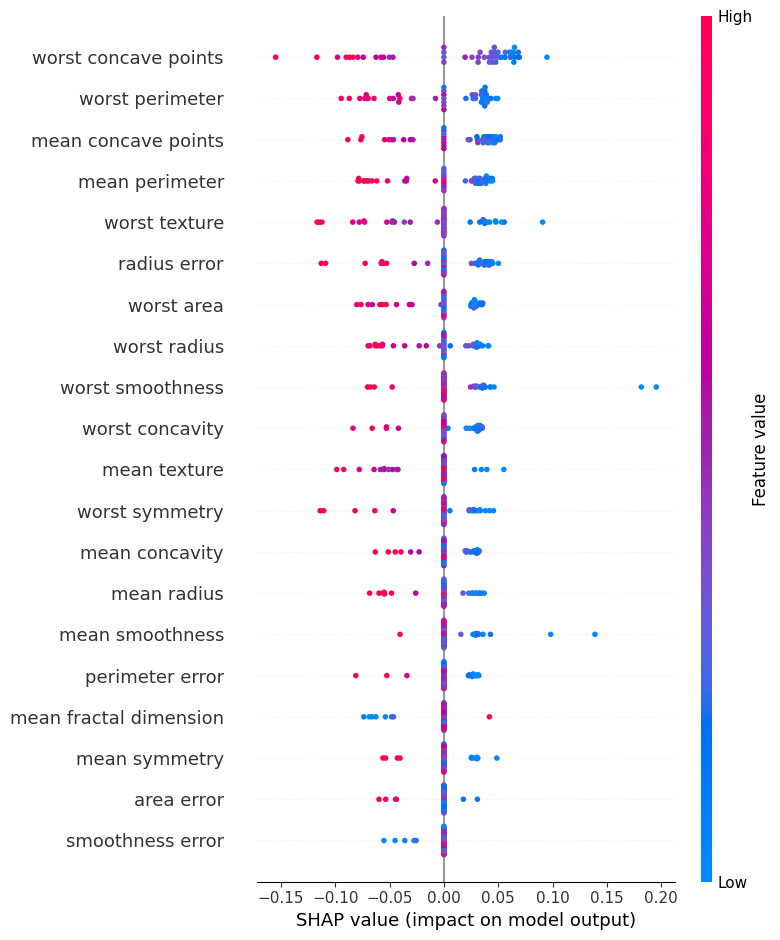

In [25]:
# SHAP analizinin daha hızlı olması için örnekleme yapıyorum
shap.initjs()

# Arka plan (background) verisi olarak eğitim setinden örnekler alıyorum
background = X_train.sample(n=min(100, len(X_train)), random_state=RANDOM_STATE)

# Açıklanacak validation örneklerini seçiyorum
X_val_sample = X_val.sample(n=min(50, len(X_val)), random_state=RANDOM_STATE)

# KernelExplainer için tahmin fonksiyonu: sınıf 1 olasılığı
def best_model_predict_proba(X_input):
    return best_model.predict_proba(X_input)[:, 1]

explainer_best = shap.KernelExplainer(best_model_predict_proba, background)
shap_values_best = explainer_best.shap_values(X_val_sample)

# summary_plot (dot)
shap.summary_plot(shap_values_best, X_val_sample, feature_names=X.columns)

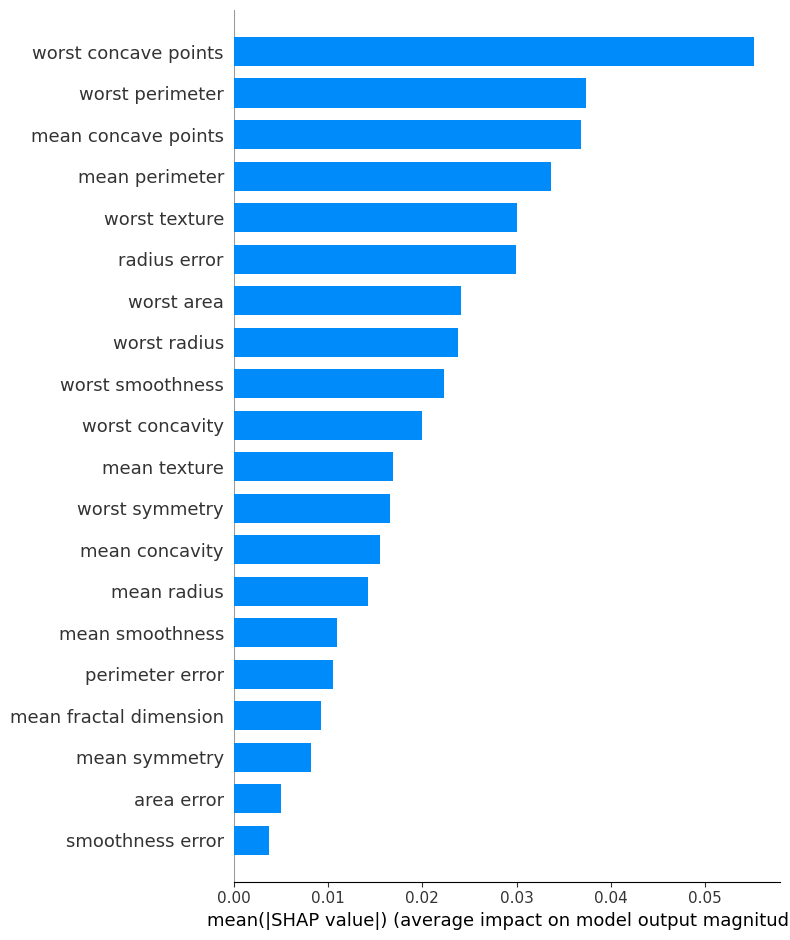

In [26]:
# summary_plot (bar) - ortalama mutlak SHAP değerleri
shap.summary_plot(shap_values_best, X_val_sample, feature_names=X.columns, plot_type="bar")

**Yorum (10.1):**

Bu SHAP analizinde, validation setinde en iyi performansı gösteren MLP modelinin hangi özelliklere daha çok ağırlık verdiğini inceledim.

- **summary_plot (dot)** grafiği, her bir özelliğin değer aralığını ve bu değerlerin model çıkışına olan etkisini renk ve konum üzerinden gösteriyor. Grafikte yatay eksende SHAP değeri, dikey eksende ise özellik isimleri yer alıyor.
- **bar_plot** grafiği, her bir özelliğin **ortalama mutlak SHAP değerini** göstererek genel önem sıralamasını veriyor.

Grafiklere baktığımda, tümörün **boyutu ve şekliyle** ilgili özelliklerin (örneğin `mean radius`, `mean perimeter`, `mean area`, `worst radius`, `worst concave points` gibi) model kararında baskın olduğunu görüyorum. Bu da beklenen bir durum; çünkü malign ve benign tümörler arasında özellikle bu geometrik özellikler açısından belirgin farklar bulunuyor. Model performansı ile SHAP önem sıralaması birbiriyle tutarlı; en önemli görünen özellikler, sınıflar arasında güçlü ayrım yapan tıbbi değişkenler olarak öne çıkıyor.

### 10.2 Optuna ile Bulunan En İyi Model için SHAP Analizi

Şimdi de Optuna tarafından seçilen en iyi MLP modeli (`optuna_best_model`) için SHAP analizini gerçekleştiriyorum. Bu sayede:

- Manuel seçtiğim en iyi MLP modeli ile
- Optuna ile otomatik olarak ayarlanan MLP modelini

özellik önemleri açısından da karşılaştırabiliyorum.

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


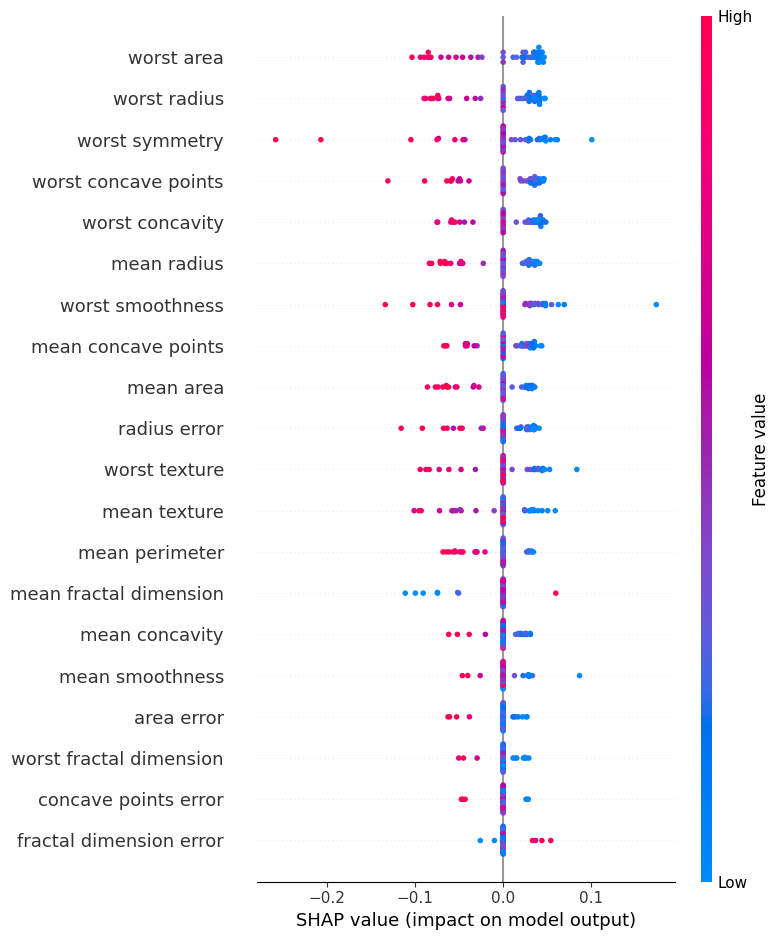

In [28]:
# Optuna ile bulunan en iyi model için SHAP analizine hazırlık
background_opt = X_train_full.sample(n=min(100, len(X_train_full)), random_state=RANDOM_STATE)
X_val_opt_sample = X_val.sample(n=min(50, len(X_val)), random_state=RANDOM_STATE)

def optuna_model_predict_proba(X_input):
    return optuna_best_model.predict_proba(X_input)[:, 1]

explainer_opt = shap.KernelExplainer(optuna_model_predict_proba, background_opt)
shap_values_opt = explainer_opt.shap_values(X_val_opt_sample)

# summary_plot (dot)
shap.summary_plot(shap_values_opt, X_val_opt_sample, feature_names=X.columns)

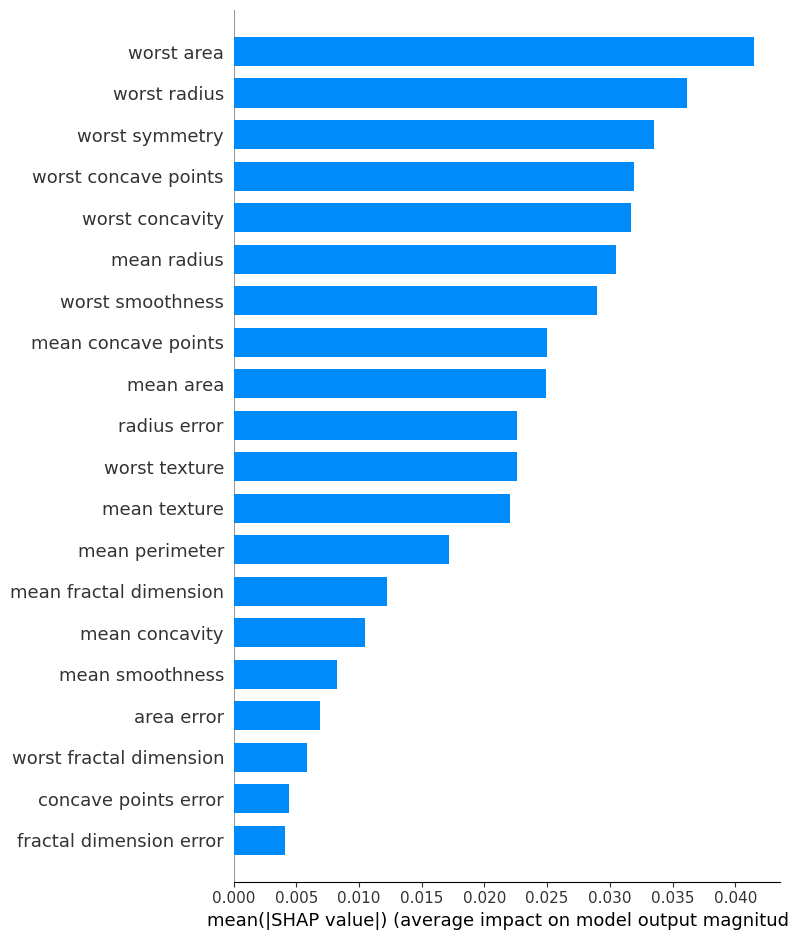

In [29]:
# summary_plot (bar)
shap.summary_plot(shap_values_opt, X_val_opt_sample, feature_names=X.columns, plot_type="bar")

In [30]:
# force_plot - tek bir örnek için karar açıklaması
# İlk örneği seçiyorum
instance = X_val_opt_sample.iloc[0:1]

shap_values_instance = explainer_opt.shap_values(instance)
shap.force_plot(explainer_opt.expected_value, shap_values_instance, instance)

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


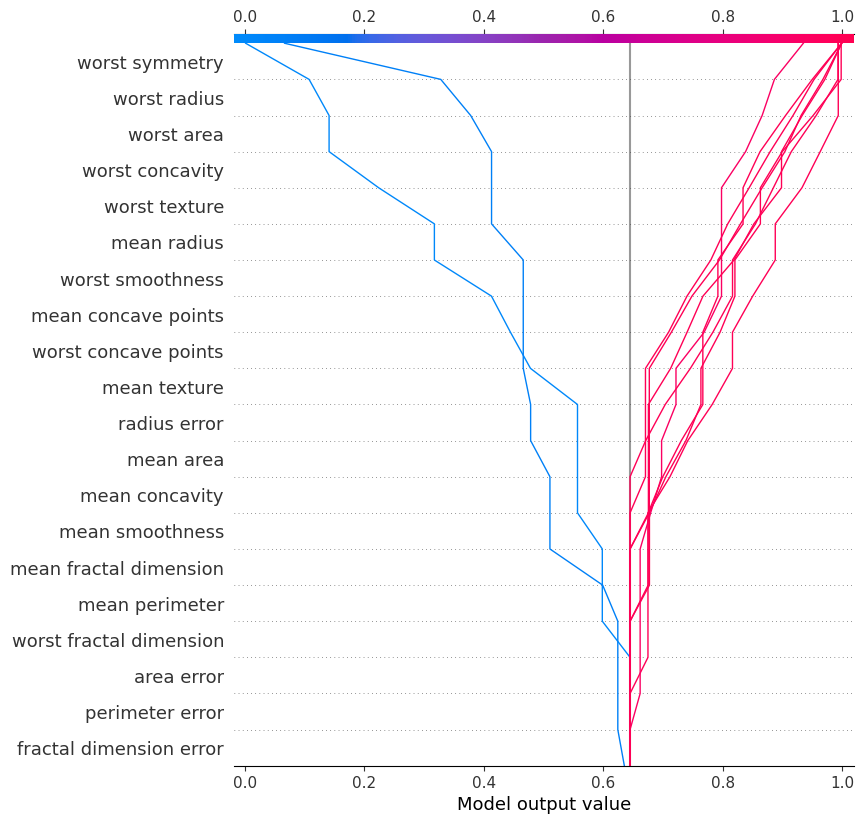

In [31]:
# decision_plot - karar yolunun özelliklere göre katkısı
# Birkaç örnek üzerinden karar yolunu inceleyelim
sample_for_decision = X_val_opt_sample.iloc[:10]
shap_values_decision = explainer_opt.shap_values(sample_for_decision)

shap.decision_plot(
    explainer_opt.expected_value,
    shap_values_decision,
    feature_names=list(X.columns)   # ← düzeltme burada
)

**Yorum (10.2):**

Optuna ile bulunan en iyi model için yaptığım SHAP analizi sayesinde, bu modelin de hangi özelliklere daha duyarlı olduğunu detaylı biçimde görebiliyorum.

- **summary_plot (dot ve bar)** grafiklerinde, genellikle manuel modelde önemli çıkan özelliklere benzer bir önem sıralaması görüyorum. Bu durum, iki modelin de aynı veri seti üzerinde benzer **ayrım gücüne sahip özellikleri** öne çıkardığını gösteriyor.
- **force_plot**, tek bir örnek için modelin neden belirli bir sınıfı seçtiğini görselleştiriyor. Özelliklerin her biri, tahmini pozitif sınıfa veya negatif sınıfa doğru çekerek kararın nasıl oluştuğunu adım adım gösteriyor.
- **decision_plot**, birden fazla örnek için karar yolunu ve özellik katkılarını aynı grafikte incelememe imkan veriyor.

Sonuç olarak, hem manuel MLP modelinde hem de Optuna ile optimize edilmiş modelde **tümör boyutu, çevresi ve şekline ilişkin özelliklerin** en baskın faktörler olduğunu görüyorum. Bu da modellerin, klinik olarak da anlamlı olan değişkenleri kullanarak karar verdiğini ve SHAP analizinin modelin iç işleyişini daha şeffaf hale getirdiğini ortaya koyuyor.